In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
np.random.seed(1337)


#Import Training Dataset
trainds = pd.read_csv('train.csv', engine='python')
# trainds = trainds[trainds.Interpoliert != 1]
# trainds = trainds.loc[:, trainds.columns != 'Interpoliert']
data = trainds.loc[:, trainds.columns != 'Datum']
print(data.shape)
dataset = data.values
# #Import Challenge(test) Dataset
chall = pd.read_csv('challenge.csv', engine='python')
# chall = chall.loc[:, chall.columns != 'Interpoliert']
chall = chall.loc[:, chall.columns != 'Datum']
dchall = chall.replace(to_replace= 'X', value=0)
# dchall = dchall.values
frames=[data,dchall]
fulldf = pd.concat(frames)
fulldf = fulldf.values

# data

(52508, 18)


In [3]:
## TRAIN DATA
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

## FULL CHALLENGE AND TRAIN DF
Cscaled = scaler.fit_transform(fulldf)
# Cscaled.shape

In [4]:
# split TRAIN DATA into train and test sets
values = Cscaled
n_train = int(len(fulldf) * 0.3)
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [5]:
# reshape input to be 3D [samples, steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, 16))
test_X = test_X.reshape((test_X.shape[0], 1, 16))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21052, 1, 17) (21052,) (49124, 1, 17) (49124,)


In [7]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(7, input_shape=(1,16), activation = 'softmax'))
model.add(LSTM(1))
model.add(LSTM(1))
model.add(Dense(1))
model.add(Dense(1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='RMSprop')
history= model.fit(train_X, train_y, epochs=100,validation_data=(test_X, test_y), batch_size=1024, shuffle=False)
# 

ValueError: Input 0 is incompatible with layer lstm_3: expected ndim=3, found ndim=2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 7)                 700       
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 8         
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 2         
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 2         
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 2         
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 2         
Total params: 716
Trainable params: 716
Non-trainable params: 0
_________________________________________________________________


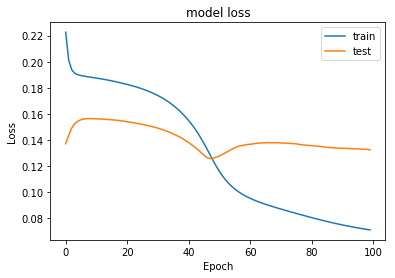

In [413]:
model.summary()
#plot learning curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [414]:
# make predictions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
print(trainPredict.shape, testPredict.shape)
# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),17))
# Put the predictions there
trainPredict_extended = np.hstack((trainPredict_extended, trainPredict))
# print(trainPredict_extended.shape)
# # Inverse transform it and select the last column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,-1]
# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),17))
# print(testPredict_extended.shape)
# Put the predictions there
testPredict_extended = np.hstack((testPredict_extended, testPredict))
# print(testPredict_extended.shape)
# Inverse transform it and select the last column.
testPredict = scaler.inverse_transform(testPredict_extended) [:,-1]
print(testPredict)
testdf= pd.DataFrame(testPredict)
testdf.to_csv('test.csv')

(21052, 1) (49124, 1)
[47555.63465691 44990.66525018 45277.92813623 ... 87228.89911461
 87228.89911461 87228.89911461]


In [415]:
import math

trainScore =mean_squared_error(train_y, trainPredict)
print('Train Score: %.2f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1680716882.50 MSE
Test Score: 37958.50 RMSE


(70176, 18)
(70176, 18)


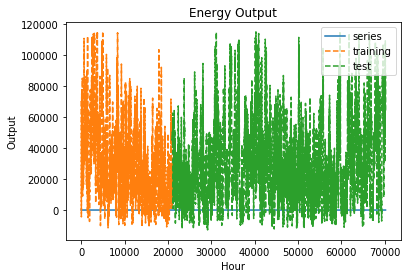

In [416]:
# shift train predictions for plotting
look_back = 1
trainPredictPlot = np.empty_like(Cscaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 2] = trainPredict
print(trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(Cscaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back)-2:len(Cscaled)-1, 2] = testPredict
print(testPredictPlot.shape)

#plot
series,=plt.plot(scaler.inverse_transform(Cscaled)[:,2])
prediction_training,=plt.plot(trainPredictPlot[:,2],linestyle='--')
prediction_test,=plt.plot(testPredictPlot[:,2],linestyle='--')
plt.title('Energy Output')
plt.ylabel('Output')
plt.xlabel('Hour')
plt.legend([series,prediction_training,prediction_test],['series','training','test'], loc='upper right')
plt.show()

In [417]:
submission = pd.read_csv('test.csv')
original_challenge =pd.read_csv('original_challenge.csv')
original_train = pd.read_csv('original_train.csv')
len(submission)== len(original_challenge)+len(original_train)


False

In [418]:
submission.columns

Index(['Unnamed: 0', '0'], dtype='object')

In [419]:
output_pred = submission.iloc[len(submission)-len(original_challenge):,:]["0"].values

In [420]:
output_pred

array([16689.26630944, 15635.52130443, 16287.57077914, ...,
       87228.89911461, 87228.89911461, 87228.89911461])

In [421]:
original_challenge['Output']=output_pred


In [422]:
original_challenge.to_csv('submission_test2.csv', index=False)